In [1]:
pip install optuna


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lxml


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import  seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from itertools import  combinations
turkish_trans_table = str.maketrans(
    "İIıÖöÜüÇçŞşĞğÜü",
    "iiioouuccssgguu")

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import optuna
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,KFold,TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)


/usr/local/python/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def cat_analyser(data, col, freq_limit = 100):
    color = '#ff661f'
    cmap1 = 'Oranges'
    cmap2 =  'Set3'
    palette1 = 'Oranges'
    palette2 = 'Set3'
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if df_[col].nunique() > freq_limit:
        df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                    keys()[:freq_limit].tolist())]
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    fig.suptitle(col, fontsize = 16)
    sns.countplot(data = df_,
                  x = col,
                  ax = ax[0],
                  palette= palette1,
                  order =  df_[col].value_counts().index)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 90)
    ax[0].set_xlabel('')
    
    
    pie_cmap = plt.get_cmap(cmap1)
    normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
    data[col].value_counts().plot.pie(autopct = '%1.1f%%',
                                      textprops = {'fontsize': 12},
                                      ax = ax[1],rotatelabels=True,
                                      colors = pie_cmap(normalize(df_[col].value_counts())))
    ax[1].set_ylabel('')
    plt.show()
#     plt.rc_file_defaults()
    sns.reset_orig()

In [7]:
df_weather=pd.read_csv('data/df_weather.csv')
df_weather.date_time=pd.to_datetime(df_weather.date_time)
df_weather.location=df_weather.location.str.translate(turkish_trans_table).str.lower()  
df_weather=df_weather.rename(columns={'date_time':'Tarih','location':'ilce'})
df_weather=df_weather[['Tarih', 'totalSnow_cm','DewPointC', 'WindChillC','WindGustKmph', 'pressure','tempC', 'windspeedKmph', 'ilce']]
df_sehzadeler=df_weather[df_weather.ilce=='turgutlu']
df_sehzadeler.ilce='sehzadeler'
df_weather=pd.concat([df_weather,df_sehzadeler],axis=0).reset_index(drop=True)

/tmp/ipykernel_18523/2392799726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sehzadeler.ilce='sehzadeler'


In [8]:
df_weather

,Tarih,totalSnow_cm,DewPointC,WindChillC,WindGustKmph,pressure,tempC,windspeedKmph,ilce
0,2021-01-01 00:00:00,0.0,9.0,10.0,10.0,1016.0,11.0,6.0,saruhanli
1,2021-01-01 01:00:00,0.0,9.0,10.0,10.0,1016.0,10.0,6.0,saruhanli
2,2021-01-01 02:00:00,0.0,9.0,10.0,10.0,1016.0,10.0,6.0,saruhanli
3,2021-01-01 03:00:00,0.0,9.0,10.0,9.0,1016.0,10.0,5.0,saruhanli
4,2021-01-01 04:00:00,0.0,9.0,10.0,9.0,1016.0,10.0,5.0,saruhanli
...,...,...,...,...,...,...,...,...,...
151742,2022-08-10 19:00:00,0.0,16.0,23.0,28.0,1006.0,23.0,15.0,sehzadeler
151743,2022-08-10 20:00:00,0.0,16.0,22.0,17.0,1007.0,22.0,9.0,sehzadeler
151744,2022-08-10 21:00:00,0.0,16.0,21.0,6.0,1007.0,21.0,3.0,sehzadeler
151745,2022-08-10 22:00:00,0.0,14.0,21.0,7.0,1007.0,21.0,3.0,sehzadeler


In [9]:
pip install unidecode


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
#getting population data( taken from Tarık Karakaş )
from unidecode import unidecode
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce =  pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[1].iloc[1:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'ilce','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'ilce','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['ilce']=ilce_nufus['ilce'].apply(unidecode).str.lower()
ilce_nufus.ilce_nufus=ilce_nufus.ilce_nufus.astype(float)*1000

In [11]:
ilce_nufus

,ilce,ilce_nufus
0,buca,522404.0
1,karabaglar,479338.0
2,bornova,454470.0
3,karsiyaka,346264.0
4,konak,332277.0
5,bayrakli,298519.0
6,cigli,214065.0
7,torbali,207840.0
8,menemen,200904.0
9,gaziemir,137754.0


# Train and Test set basic preprocessing

In [12]:

def data_preprocessing(df_temp,drop_cols):
    df_temp.columns=df_temp.columns.str.translate(turkish_trans_table).str.lower()  
    df_temp=df_temp.apply(lambda x : x.str.translate(turkish_trans_table).str.lower() if x.dtype==object else x)
    df_temp.baslama_tarihi_ve_zamani=pd.to_datetime(df_temp.baslama_tarihi_ve_zamani,dayfirst=True)
    df_temp.sona_erme_tarihi_ve_zamani=pd.to_datetime(df_temp.sona_erme_tarihi_ve_zamani,dayfirst=True)
    df_temp['Tarih']=df_temp.baslama_tarihi_ve_zamani.map(lambda  x : x.strftime('%Y-%m-%d %H:00:00'))
    df_temp.Tarih=pd.to_datetime(df_temp.Tarih)
    df_temp=df_temp.merge(ilce_nufus,how='left',on='ilce')
    df_temp['il_ilce']=df_temp.il+'_'+df_temp.ilce
    df_temp.drop(drop_cols,axis=1,inplace=True)
    return df_temp

def timeseries_features(df, label=None):
    df['datetime'] = pd.to_datetime(df.index)
    df['hour'] = df['datetime'].dt.hour
    # df['date'] = df['datetime'].dt.date
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['month'] = df['datetime'].dt.month
    # df['year'] = df['datetime'].dt.year
    # df['dayofyear'] = df['datetime'].dt.dayofyear
    df['dayofmonth'] = df['datetime'].dt.day
    # df['weekofyear'] = df['datetime'].dt.weekofyear
    df['weekday']=df['datetime'].dt.weekday
    df['wntr_month']=df.apply(lambda x: 1 if x.month in ([11,12,1,2]) else 0,axis=1) 
    df['month_label']=df.month.map(lambda x : '1' if x in ([11,12,1,2,3]) else ( '2' if x in ([6,7,8,9]) else '3' ))
    df['quarter']=df.month.map(lambda x : '1_çeyrek' if x in ([1,2,3]) else ( '2_çeyrek' if x in ([4,5,6]) else( '3_çeyrek' if x in ([7,8,9]) else '4_çeyrek') ))
    df['season']=df.month.map(lambda x : 'kış' if x in ([12,1,2]) else ( 'ilkbahar' if x in ([3,4,5]) else( 'yaz' if x in ([6,7,8]) else 'sonbahar') ))
    df['weekend']=df.dayofmonth.map(lambda x:  'hafta_içi' if x<5 else 'hafta_sonu')
    # df['working_hours']=df.hour.map(lambda x: 'work_hour' if (x<7) & (x>19) else 'not_work_hour' )
    df['label_hour']=df.hour.map(lambda x : '1' if x>22 & x<24 else ('2' if x>0 & x<6 else ('3' if x>5 & x<10 else ('4' if x>9 & x<13  else ('5' if x>12 & x<17 else('6' if x>16 & x<21 else '7'))) )))
    df['prime_time']=df.hour.map(lambda x: 'prime' if (x>19) & (x<22) else 'not_prime' )
    df=df.drop('datetime',axis=1)
    return df 

def cat_target_encode(train_temp,test_temp,target,cat_cols,encode_type='mean'):
    if type(cat_cols)==str:
        cat_cols=[cat_cols]
    dum_temp=train_temp.groupby(cat_cols).agg({target:encode_type}).reset_index().rename(columns={target:str("_".join(cat_cols))+'_te'})
    train_temp=train_temp.merge(dum_temp,on=cat_cols,how='left').set_index(train_temp.index)
    test_temp=test_temp.merge(dum_temp,on=cat_cols,how='left').set_index(test_temp.index)
    
    return train_temp,test_temp

def label_data(feature,data,le_fit=None):
    if type(feature)==str:
        feature=[feature]
    for col in feature:
        le=LabelEncoder()
        le_fit.update({col:le.fit(data[col])})
        data[col]=le.transform(data[col])
    return data[feature],le_fit

def cat_feature_count(df_temp,obj_cols,fig_size):
    for col in obj_cols:
        sns.set(rc={'figure.figsize':fig_size,'axes.facecolor':'lightgreen', 'figure.facecolor':'cornflowerblue'})
        g=sns.countplot(y=df_temp[col],order = df_temp[col].value_counts().index)
        g.set_xticklabels(g.get_xticklabels(), rotation=90);
        for label in g.containers:
            g.bar_label(label,padding=10, fontsize=10)
        plt.show()

In [13]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
drop_cols=['kesinti_no','kademe','outageid','sebeke_unsuru_kodu','bildirime_gore']
train=data_preprocessing(train,drop_cols)
train.drop('kod_no',axis=1,inplace=True)
test=data_preprocessing(test,drop_cols)
train=timeseries_features(train.set_index('Tarih'))
test=timeseries_features(test.set_index('Tarih'))
train=train.sort_index()
test=test.sort_index()

diff=train.sona_erme_tarihi_ve_zamani-train.baslama_tarihi_ve_zamani
train['ariza_suresi']=diff.dt.total_seconds()/3600

diff=test.sona_erme_tarihi_ve_zamani-test.baslama_tarihi_ve_zamani
test['ariza_suresi']=diff.dt.total_seconds()/3600


In [14]:
obj_cols=[ 'il', 'ilce', 'sebeke_unsuru',
   'kesinti_nedenine_iliskin_aciklama', 'kaynaga_gore', 'sureye_gore',
   'sebebe_gore','il_ilce','dayofweek', 'quarter',
   'month', 'dayofmonth', 'weekday', 'wntr_month','hour',
   'month_label', 'season', 'weekend', 'label_hour',
   'prime_time']
train[obj_cols]=train[obj_cols].astype(object)
time_cols=['baslama_tarihi_ve_zamani','sona_erme_tarihi_ve_zamani']
num_cols=[col for col in train.columns if train[col].dtype in ['float','int']]
display(train[obj_cols].describe())
display(train.describe())

,il,ilce,sebeke_unsuru,kesinti_nedenine_iliskin_aciklama,kaynaga_gore,sureye_gore,sebebe_gore,il_ilce,dayofweek,quarter,month,dayofmonth,weekday,wntr_month,hour,month_label,season,weekend,label_hour,prime_time
count,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277,37277
unique,2,47,8,63,3,2,4,47,7,2,6,31,7,2,24,3,3,2,3,2
top,izmir,cesme,abone tesisi,ag havai bransman arizasi,dagitim-ag,uzun,sebeke isletmecisi,izmir_cesme,3,1_çeyrek,4,11,3,0,10,1,ilkbahar,hafta_sonu,1,not_prime
freq,26163,2454,13465,7043,26615,36532,36509,2454,5829,19936,7428,1834,5829,23491,2747,19936,19906,30756,27984,34316


,baslama_tarihi_ve_zamani,sona_erme_tarihi_ve_zamani,kesinti_suresi,kentsel_og,kentsel_ag,kentalti_og,kentalti_ag,kirsal_og,kirsal_ag,toplam_kentsel_og,toplam_kentsel_ag,toplam_kentalti_og,toplam_kentalti_ag,toplam_kirsal_og,toplam_kirsal_ag,cagri_count,ilce_nufus,ariza_suresi
count,37277,37277,37277.000000,37277.000000,37277.000000,37277.000000,37277.000000,37277.000000,37277.000000,37277.000000,37276.000000,37276.000000,37276.000000,37276.000000,37276.000000,37276.000000,37136.000000,37277.000000
mean,2022-03-23 22:53:03.678246656,2022-03-24 01:06:07.646430976,2.217770,8.884299,359.604233,1.470022,50.806771,2.866674,57.588433,8.104658,294.521081,1.105874,38.119798,2.313139,45.068694,4.746593,160653.754228,2.217769
min,2022-01-01 00:04:48,2022-01-01 01:21:39,-2.962778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.414444,-2233.601389,0.000000,0.000000,0.000000,0.000000,0.000000,12030.000000,-2.962778
25%,2022-02-08 07:37:38,2022-02-08 09:26:12,0.915833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48924.000000,0.915833
50%,2022-03-24 18:59:33,2022-03-24 21:32:14,1.667778,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.539027,0.000000,0.000000,0.000000,0.000000,0.000000,114250.000000,1.667778
75%,2022-05-05 13:19:03,2022-05-05 14:48:48,2.892222,0.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,109.688958,0.000000,0.000000,0.000000,0.000000,2.000000,207840.000000,2.892222
max,2022-06-12 23:58:01,2022-06-13 08:45:29,170.721667,1160.000000,70961.000000,735.000000,21970.000000,482.000000,11683.000000,1862.275000,51555.312219,3849.358333,74001.949997,1440.486666,27071.201666,2223.000000,522404.000000,170.721667
std,NaN,NaN,2.148557,41.442642,1794.608614,13.641379,484.578227,19.205432,366.607191,50.046424,1398.581884,23.031174,520.864515,23.420136,367.921493,31.365842,132944.380024,2.148558


In [15]:
test[obj_cols]=test[obj_cols].astype(object)
display(test[obj_cols].describe())
display(test.describe())
print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))

,il,ilce,sebeke_unsuru,kesinti_nedenine_iliskin_aciklama,kaynaga_gore,sureye_gore,sebebe_gore,il_ilce,dayofweek,quarter,month,dayofmonth,weekday,wntr_month,hour,month_label,season,weekend,label_hour,prime_time
count,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751,16751
unique,2,47,8,61,3,2,4,47,7,2,3,31,7,1,24,1,1,2,3,2
top,izmir,odemis,abone tesisi,og fider acmasi,dagitim-ag,uzun,sebeke isletmecisi,izmir_odemis,0,3_çeyrek,7,18,0,0,10,2,yaz,hafta_sonu,1,not_prime
freq,11111,1023,4613,3747,10651,16422,16351,1023,2728,12040,7575,918,2728,16751,1175,16751,16751,14798,12161,15038


,baslama_tarihi_ve_zamani,sona_erme_tarihi_ve_zamani,kesinti_suresi,kentsel_og,kentsel_ag,kentalti_og,kentalti_ag,kirsal_og,kirsal_ag,toplam_kentsel_og,toplam_kentsel_ag,toplam_kentalti_og,toplam_kentalti_ag,toplam_kirsal_og,toplam_kirsal_ag,ilce_nufus,ariza_suresi
count,16751,16751,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16751.000000,16709.000000,16751.000000
mean,2022-07-16 10:27:15.818995968,2022-07-16 12:25:59.840785408,1.978896,10.326130,378.501642,1.923169,72.799594,3.242612,71.696018,9.351769,334.848706,1.393047,52.099334,2.451075,57.454483,152932.559339,1.978895
min,2022-06-13 00:32:49,2022-06-13 01:50:23,0.000556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12030.000000,0.000556
25%,2022-06-28 18:43:49.500000,2022-06-28 20:31:57.500000,0.823194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48924.000000,0.823194
50%,2022-07-17 00:59:37,2022-07-17 03:29:30,1.514167,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.758611,0.000000,0.000000,0.000000,0.000000,111218.000000,1.514167
75%,2022-08-02 10:27:51,2022-08-02 12:49:39,2.595139,1.000000,95.500000,0.000000,0.000000,0.000000,0.000000,1.069722,110.945139,0.000000,0.000000,0.000000,0.000000,200904.000000,2.595139
max,2022-08-21 23:47:37,2022-08-22 02:48:00,18.770556,1984.000000,67245.000000,750.000000,22338.000000,473.000000,11661.000000,6374.702221,216061.920796,921.457778,52927.600000,1222.417778,57794.540554,522404.000000,18.770556
std,NaN,NaN,1.694035,47.158962,1852.414784,15.338334,630.921066,19.662344,440.279770,67.166184,2707.840696,16.132761,595.825375,23.825774,716.653178,127082.156324,1.694036


train shape: (37277, 38)
test shape: (16751, 37)


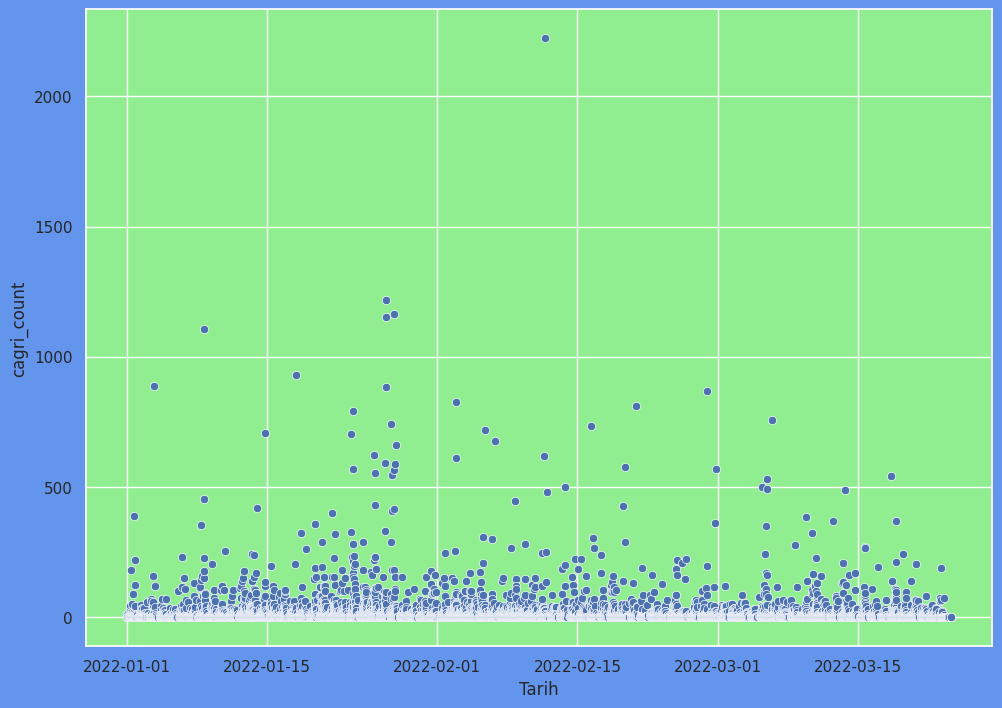

In [16]:
train=train[:'2022-03-24 07:00:00']
sns.set(rc={'figure.figsize':(11.7,8.27),'axes.facecolor':'lightgreen', 'figure.facecolor':'cornflowerblue'})
sns.scatterplot(train.cagri_count);

In [17]:
dum=train.groupby(['il','ilce']).agg({'kentsel_og':'mean','kentsel_ag':'mean','kentalti_og':'mean','kentalti_ag':'mean','kirsal_og':'mean','kirsal_ag':'mean'})
dum.columns=['kentsel_og_mean','kentsel_ag_mean','kentalti_og_mean','kentalti_ag_mean','kirsal_og_mean','kirsal_ag_mean']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)

dum=train.groupby(['il','ilce']).agg({'toplam_kentsel_og':'mean','toplam_kentsel_ag':'mean','toplam_kentalti_og':'mean','toplam_kentalti_ag':'mean','toplam_kirsal_og':'mean','toplam_kirsal_ag':'mean'})
dum.columns=['Toplam_kentsel_og_mean','toplam_kentsel_ag_mean','toplam_kentalti_og_mean','toplam_kentalti_ag_mean','toplam_kirsal_og_mean','toplam_kirsal_ag_mean']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)

dum=train.groupby(['il','ilce']).agg({'kentsel_og':'sum','kentsel_ag':'sum','kentalti_og':'sum','kentalti_ag':'sum','kirsal_og':'sum','kirsal_ag':'sum'})
dum.columns=['kentsel_og_sum','kentsel_ag_sum','kentalti_og_sum','kentalti_ag_sum','kirsal_og_sum','kirsal_ag_sum']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)

dum=train.groupby(['il','ilce']).agg({'toplam_kentsel_og':'sum','toplam_kentsel_ag':'sum','toplam_kentalti_og':'sum','toplam_kentalti_ag':'sum','toplam_kirsal_og':'sum','toplam_kirsal_ag':'sum'})
dum.columns=['Toplam_kentsel_og_sum','toplam_kentsel_ag_sum','toplam_kentalti_og_sum','toplam_kentalti_ag_sum','toplam_kirsal_og_sum','toplam_kirsal_ag_sum']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)

In [18]:
train,test=cat_target_encode(train,test,'cagri_count',['il', 'ilce','sebebe_gore'])
train,test=cat_target_encode(train,test,'cagri_count',['season', 'weekend'])
train,test=cat_target_encode(train,test,'cagri_count',['kaynaga_gore', 'sureye_gore'])
train,test=cat_target_encode(train,test,'cagri_count',['kaynaga_gore', 'sureye_gore','sebebe_gore'])
train,test=cat_target_encode(train,test,'cagri_count',['quarter','month'])
train,test=cat_target_encode(train,test,'cagri_count',['il', 'ilce','sebebe_gore'])
train,test=cat_target_encode(train,test,'cagri_count',[ 'weekend','label_hour','prime_time'])

# Merging Train and Test data

In [19]:
data=pd.concat([train,test])
lbls=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450','450-500', '500-550']
data['nufus_label']=pd.cut(data.ilce_nufus,bins=list(range(0,600000,50000)), labels=lbls,ordered=False,right=False) 
# data.drop(['baslama_tarihi_ve_zamani', 'sona_erme_tarihi_ve_zamani', 'kentalti_og','toplam_kentalti_og', 'kentalti_ag'],axis=1,inplace=True)


In [20]:
dum_label=data.kesinti_nedenine_iliskin_aciklama.value_counts()[data.kesinti_nedenine_iliskin_aciklama.value_counts()<400].index
data.loc[data.kesinti_nedenine_iliskin_aciklama.isin(dum_label),'kesinti_nedenine_iliskin_aciklama']='unknown'

data.kesinti_suresi=data.kesinti_suresi*60
dum=data[data.cagri_count.notnull()].groupby(['sebebe_gore','il_ilce'])[['kesinti_suresi','cagri_count']].mean().reset_index()
dum['s_g_c']=dum.kesinti_suresi/dum.cagri_count
dum.replace([np.inf, -np.inf], 0, inplace=True)
data=data.merge(dum[['sebebe_gore','il_ilce','s_g_c']],how='left',on=['sebebe_gore','il_ilce']).set_index(data.index)

dum=data[data.cagri_count.notnull()].groupby(['kaynaga_gore','il_ilce'])[['kesinti_suresi','cagri_count']].mean().reset_index()
dum['k_g_c']=dum.kesinti_suresi/dum.cagri_count
dum.replace([np.inf, -np.inf], 0, inplace=True)
data=data.merge(dum[['kaynaga_gore','il_ilce','k_g_c']],how='left',on=['kaynaga_gore','il_ilce']).set_index(data.index)

In [21]:
#unique categorical variables and their labels
for obj_col in obj_cols:
    print(obj_col)
    print("----------")
    print(data[obj_col].unique())
    print("\n----------\n")

il
----------
['izmir' 'manisa']

----------

ilce
----------
['odemis' 'buca' 'karabaglar' 'konak' 'cesme' 'sehzadeler' 'saruhanli'
 'foca' 'yunusemre' 'kemalpasa' 'gaziemir' 'alasehir' 'dikili' 'torbali'
 'beydag' 'seferihisar' 'urla' 'akhisar' 'bayrakli' 'soma' 'menderes'
 'menemen' 'tire' 'turgutlu' 'salihli' 'cigli' 'kula' 'bornova'
 'karaburun' 'karsiyaka' 'koprubasi' 'selcuk' 'narlidere' 'demirci'
 'kiraz' 'aliaga' 'golmarmara' 'kirkagac' 'guzelbahce' 'bayindir'
 'bergama' 'selendi' 'sarigol' 'gordes' 'balcova' 'kinik' 'ahmetli']

----------

sebeke_unsuru
----------
['dagitim transformatoru' 'ag fideri' 'abone tesisi'
 'saha dagitim kutusu (sdk)' 'kok' 'og fideri' 'dm' 'tm fideri']

----------

kesinti_nedenine_iliskin_aciklama
----------
['ag termik acmasi' 'ag pano kol sigorta atigi'
 'ag box / sdk abone cikis sigorta atigi' 'ag tel kopugu'
 'ag box / sdk giris sigorta atigi' 'unknown' 'ag havai bransman arizasi'
 'og fider acmasi' 'ag direkten kesme acma' 'og sigorta atmasi'

In [22]:
# Desciptions of Merged datas  
obj_cols=[col for  col in data.columns if data[col].dtype==object]
time_cols=['Tarih','baslama_tarihi_ve_zamani','sona_erme_tarihi_ve_zamani']
num_cols=[col for col in data.columns if data[col].dtype in ['float','int']]
display(data[obj_cols].describe())
display(data.describe())

,il,ilce,sebeke_unsuru,kesinti_nedenine_iliskin_aciklama,kaynaga_gore,sureye_gore,sebebe_gore,il_ilce,hour,dayofweek,quarter,month,dayofmonth,weekday,wntr_month,month_label,season,weekend,label_hour,prime_time
count,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247,35247
unique,2,47,8,14,3,2,4,47,24,7,3,6,31,7,2,2,3,2,3,2
top,izmir,cesme,abone tesisi,og fider acmasi,dagitim-ag,uzun,sebeke isletmecisi,izmir_cesme,10,2,1_çeyrek,7,18,2,0,1,yaz,hafta_sonu,1,not_prime
freq,24646,2162,11690,6510,24680,34545,34509,2162,2566,5564,18496,7575,1721,5564,21461,18496,16751,30504,26139,32090


,baslama_tarihi_ve_zamani,sona_erme_tarihi_ve_zamani,kesinti_suresi,kentsel_og,kentsel_ag,kentalti_og,kentalti_ag,kirsal_og,kirsal_ag,toplam_kentsel_og,toplam_kentsel_ag,toplam_kentalti_og,toplam_kentalti_ag,toplam_kirsal_og,toplam_kirsal_ag,cagri_count,ilce_nufus,ariza_suresi,kentsel_og_mean,kentsel_ag_mean,kentalti_og_mean,kentalti_ag_mean,kirsal_og_mean,kirsal_ag_mean,Toplam_kentsel_og_mean,...,toplam_kentalti_og_mean,toplam_kentalti_ag_mean,toplam_kirsal_og_mean,toplam_kirsal_ag_mean,kentsel_og_sum,kentsel_ag_sum,kentalti_og_sum,kentalti_ag_sum,kirsal_og_sum,kirsal_ag_sum,Toplam_kentsel_og_sum,toplam_kentsel_ag_sum,toplam_kentalti_og_sum,toplam_kentalti_ag_sum,toplam_kirsal_og_sum,toplam_kirsal_ag_sum,il_ilce_sebebe_gore_te_x,season_weekend_te,kaynaga_gore_sureye_gore_te,kaynaga_gore_sureye_gore_sebebe_gore_te,quarter_month_te,il_ilce_sebebe_gore_te_y,weekend_label_hour_prime_time_te,s_g_c,k_g_c
count,35247,35247,35247.000000,35247.000000,35247.000000,35247.000000,35247.000000,35247.000000,35247.000000,35247.000000,35246.000000,35246.000000,35246.000000,35246.000000,35246.000000,18495.000000,35148.000000,35247.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,...,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,35199.000000,18496.000000,35247.000000,35244.000000,18496.000000,35199.000000,35247.000000,35199.000000,35217.000000
mean,2022-04-25 07:06:47.225040384,2022-04-25 09:13:28.108179456,126.681424,8.840979,354.936988,1.649275,61.020144,2.935484,62.286975,7.811893,301.943913,1.115210,41.009737,2.173939,47.340649,9.562909,160898.684221,2.111356,7.495945,333.595534,1.401222,50.352022,2.657331,53.765625,6.417295,...,0.863535,30.965887,1.922839,38.179254,3869.785521,181720.139922,609.047956,27009.217615,1202.187122,26111.611267,3249.807195,151128.256444,373.770837,18755.423260,836.794160,18744.581328,9.077517,9.562971,10.893531,10.855286,9.563025,9.077517,9.762539,23.568103,33.668968
min,2022-01-01 00:04:48,2022-01-01 01:21:39,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12030.000000,0.000556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.647989,0.000000,0.000000,7.468365,0.000000,4.816327,0.000000,0.000000
25%,2022-02-05 19:07:55,2022-02-05 21:32:50.500000,53.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,48924.000000,0.885417,0.838991,187.555102,0.000000,0.000000,0.000000,0.000000,0.676839,...,0.000000,0.000000,0.000000,0.000000,758.000000,86530.000000,0.000000,0.000000,0.000000,0.000000,626.512237,57957.865201,0.000000,0.000000,0.000000,0.000000,4.368932,7.957399,4.764492,4.698003,7.468365,4.368932,8.462392,10.923575,11.494460
50%,2022-03-19 21:08:28,2022-03-19 23:45:10,96.133333,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.240556,0.000000,0.000000,0.000000,0.000000,2.000000,114250.000000,1.602222,4.827020,302.096023,0.291066,0.009479,0.453125,16.679945,4.618756,...,0.125977,0.007220,0.378419,13.512999,3471.000000,152161.000000,90.000000,4.000000,216.000000,10723.000000,1696.223065,140839.104112,33.340834,3.046667,277.380834,7052.367217,5.841975,10.720640,4.764492,4.698003,8.726820,5.841975,8.462392,17.655942,32.107253
75%,2022-07-14 18:22:49.500000,2022-07-14 19:59:26.500000,164.600000,1.000000,85.000000,0.000000,0.000000,0.000000,0.000000,0.152778,109.532083,0.000000,0.000000,0.000000,0.000000,5.000000,207840.000000,2.743333,13.525234,431.894397,1.529412,99.821938,3.314775,86.239567,9.559185,...,0.861023,48.512840,2.648545,51.357166,6499.000000,310618.000000,831.000000,2

In [23]:
# sns.set(rc={'figure.figsize':(15,10)})
# ax=sns.lineplot(x=list(data.index),y=data.cagri_count,hue=data.month,legend=all,linewidth=3,style=data.month)
# ax.set_title('Aylara göre saatlik değişimler')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.set_xticks(range(0,24));

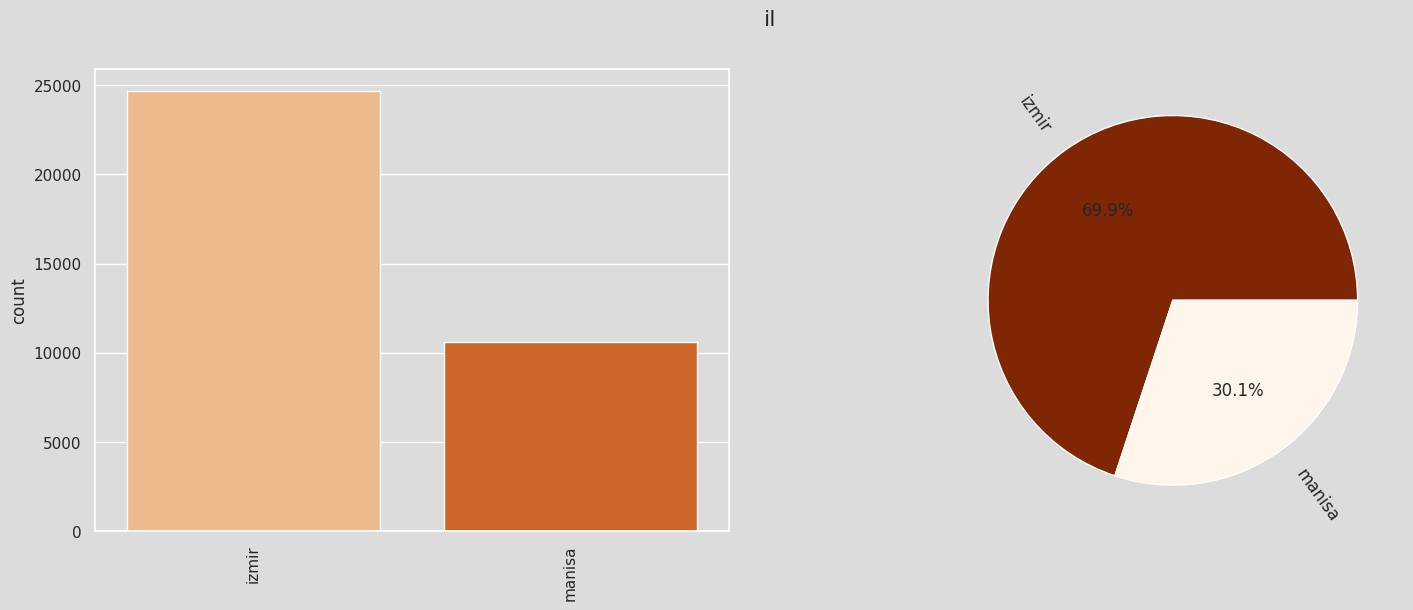

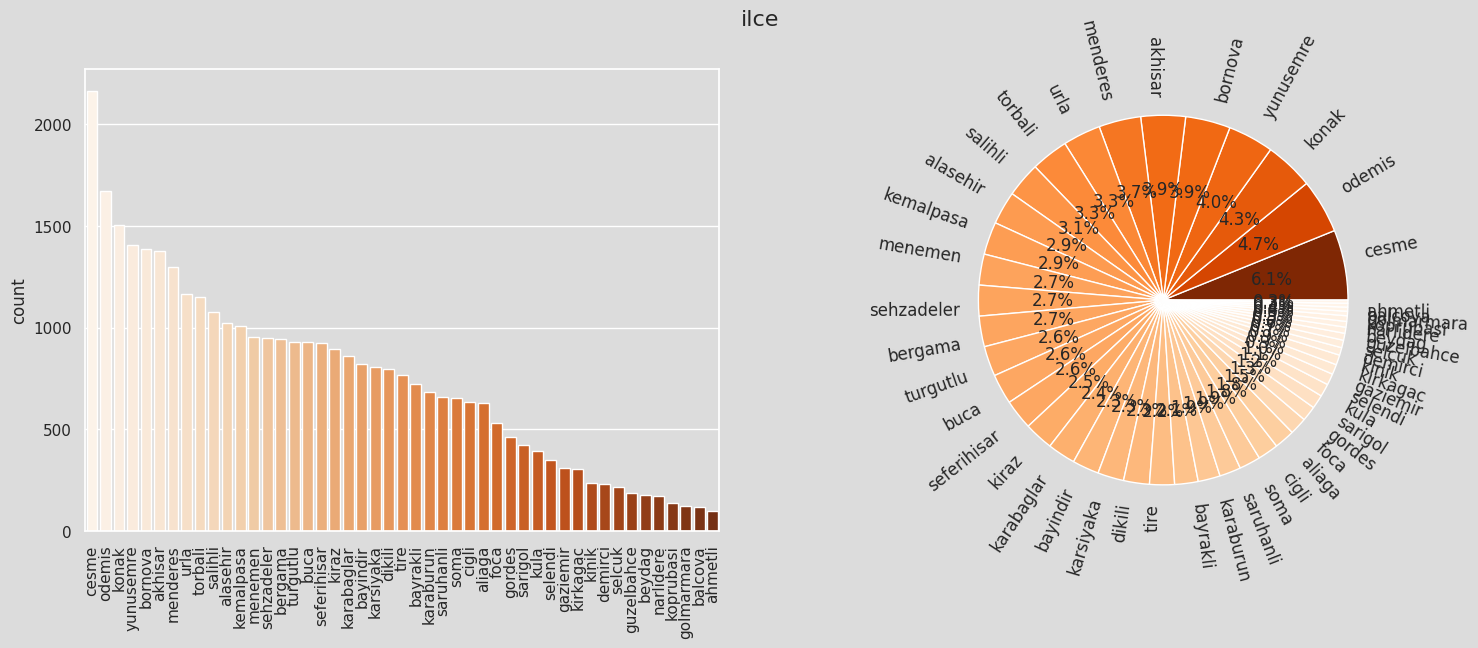

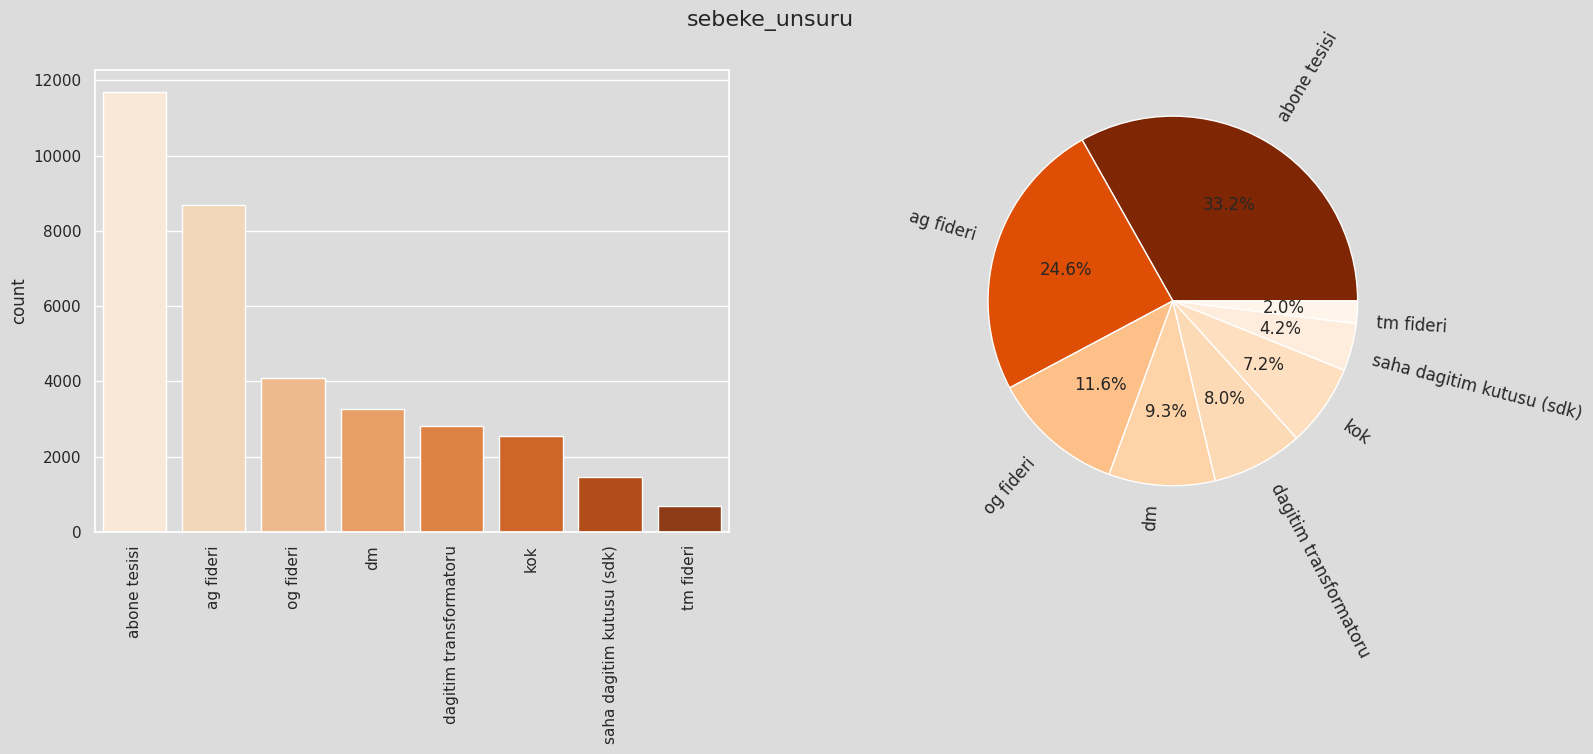

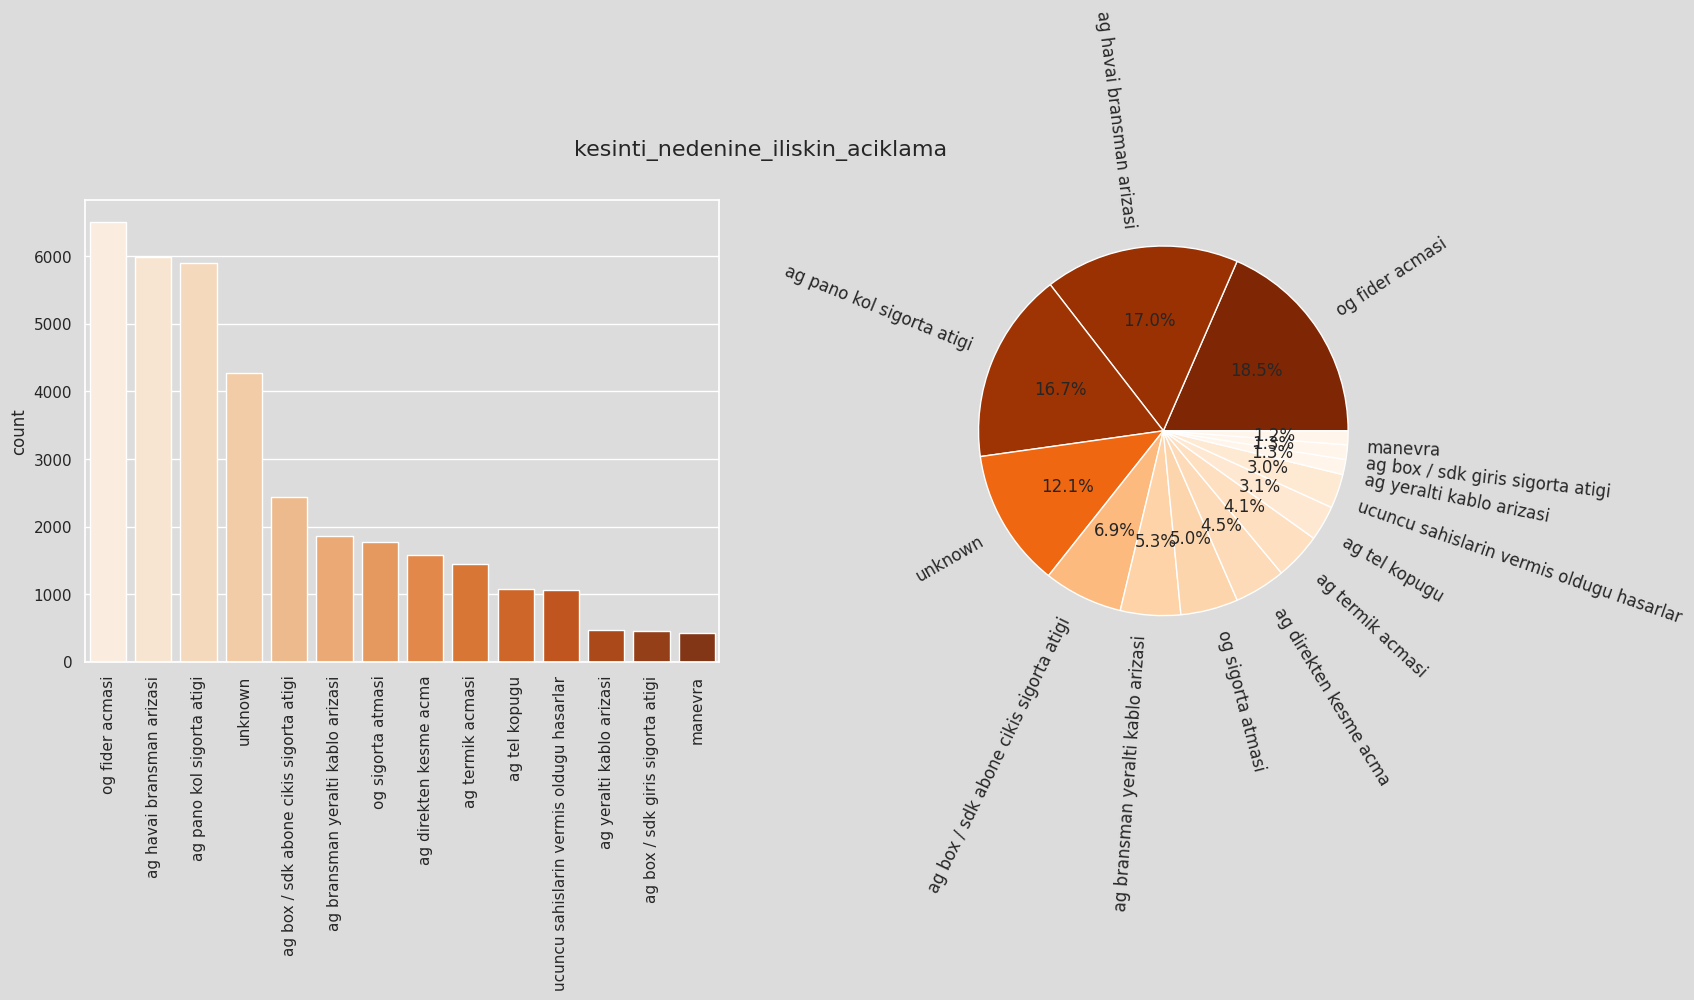

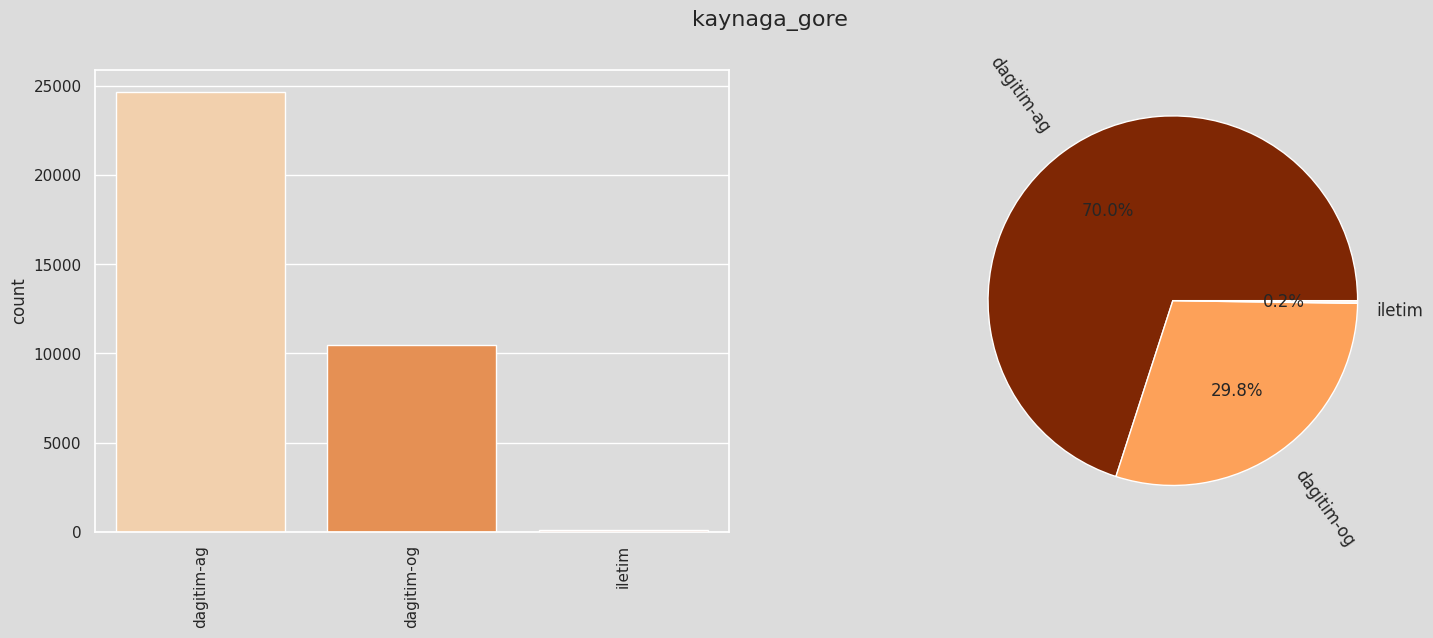

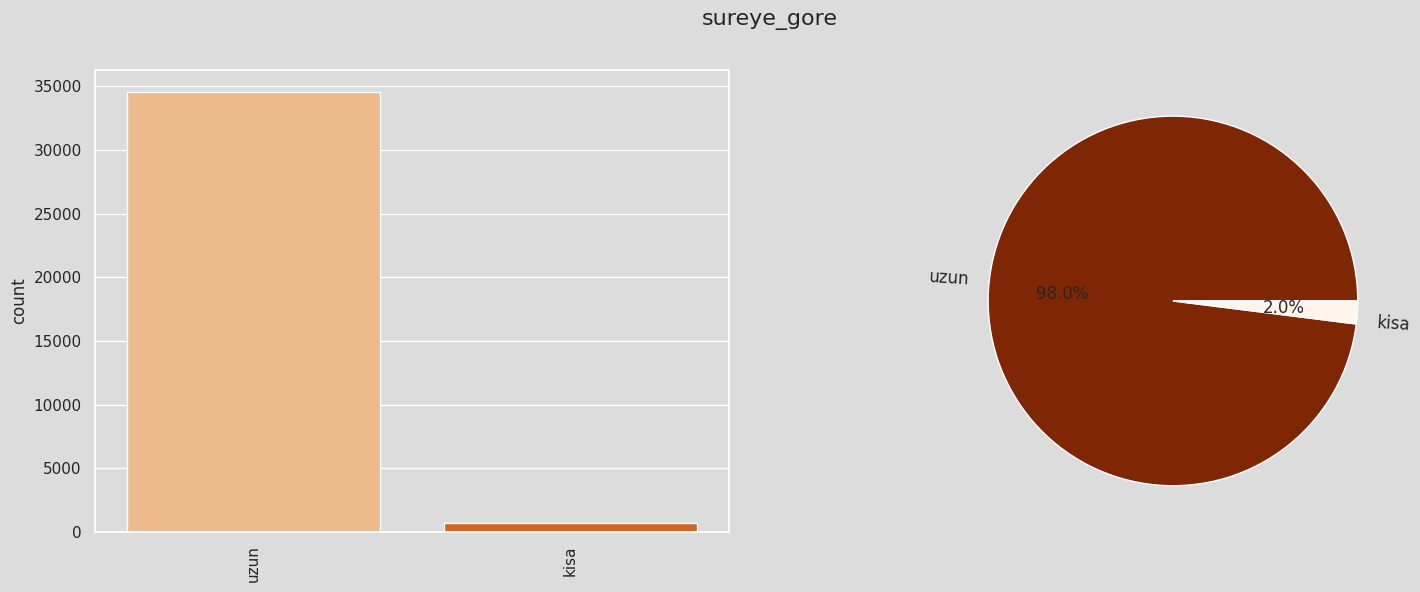

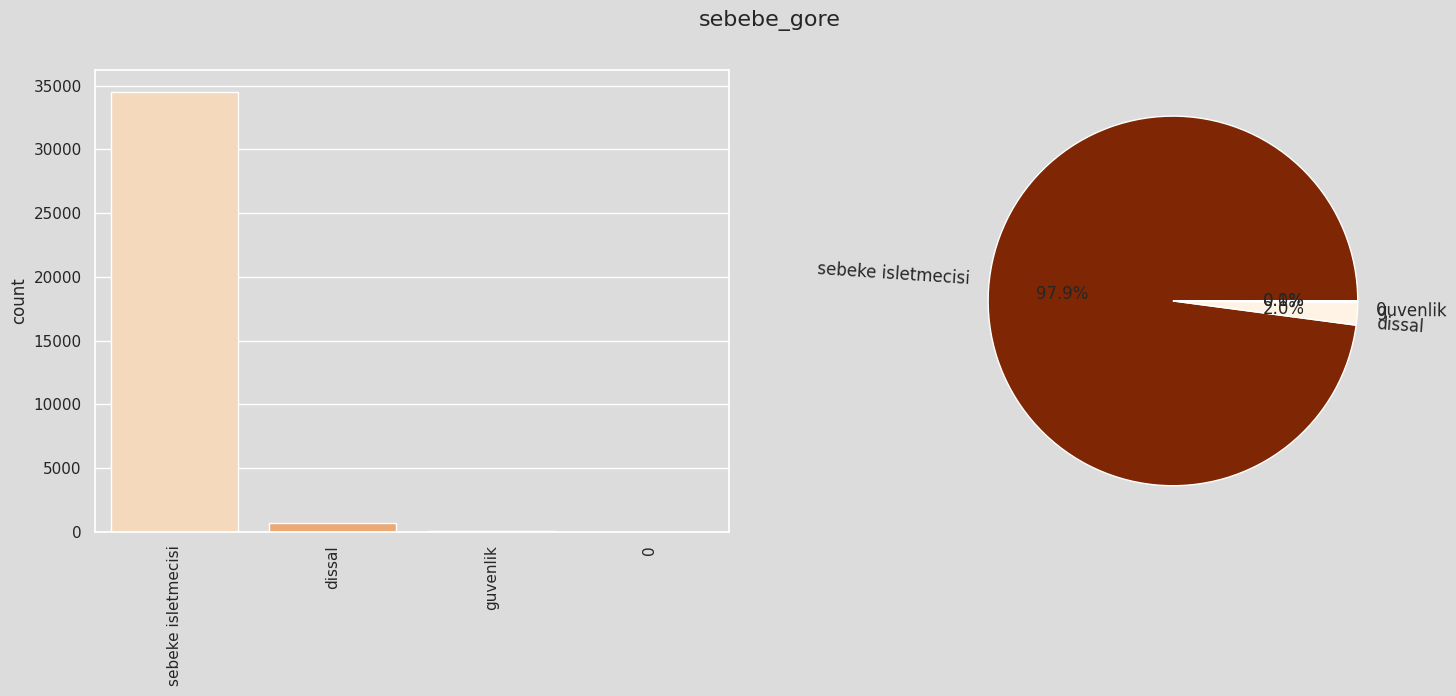

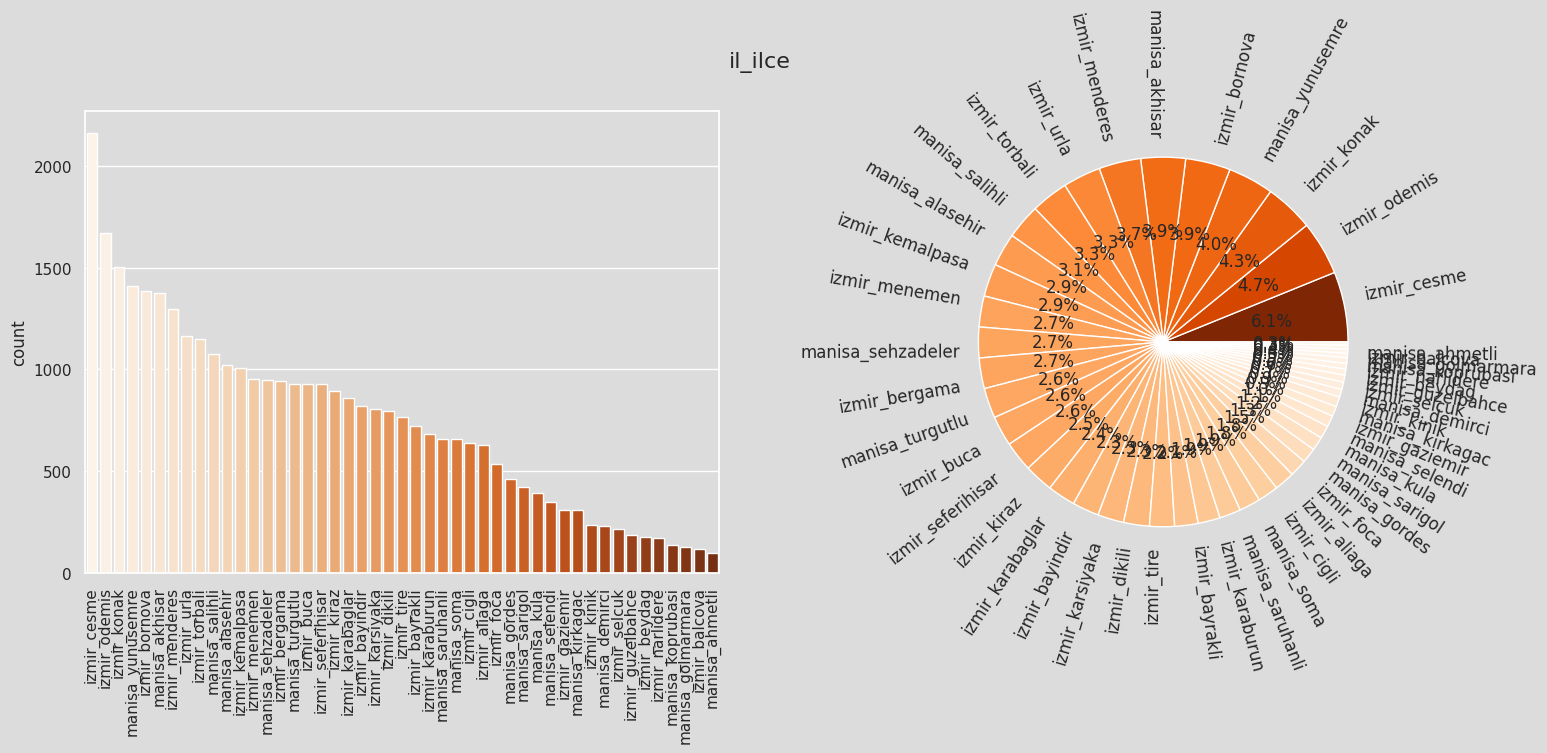

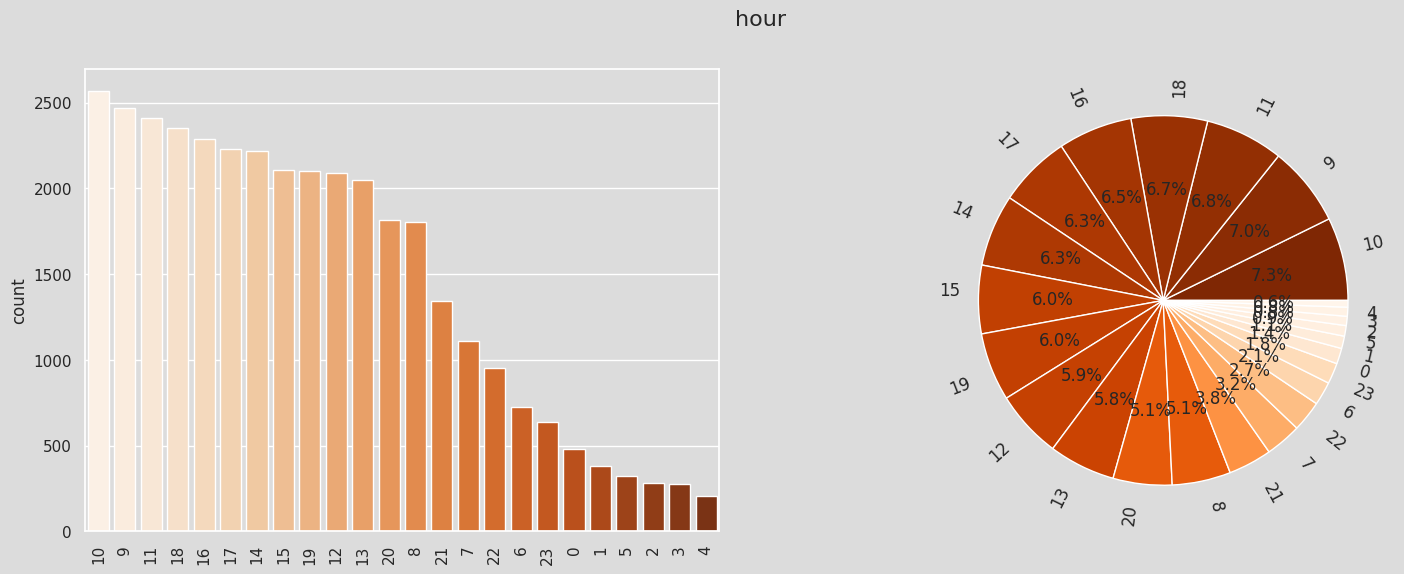

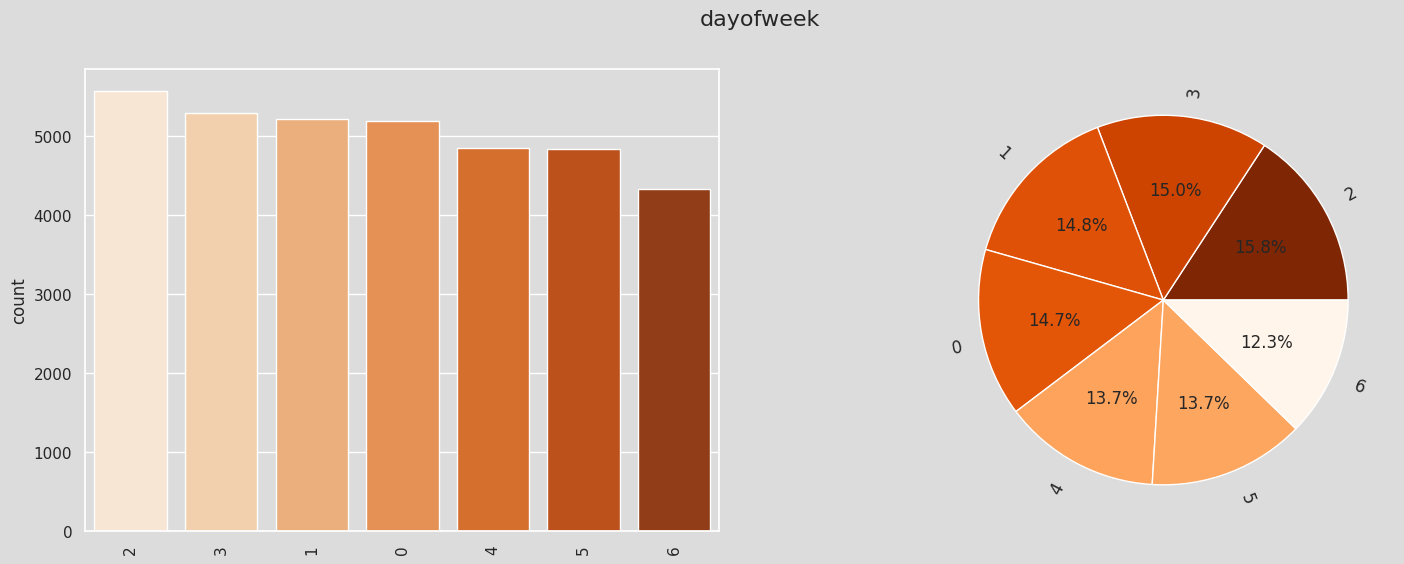

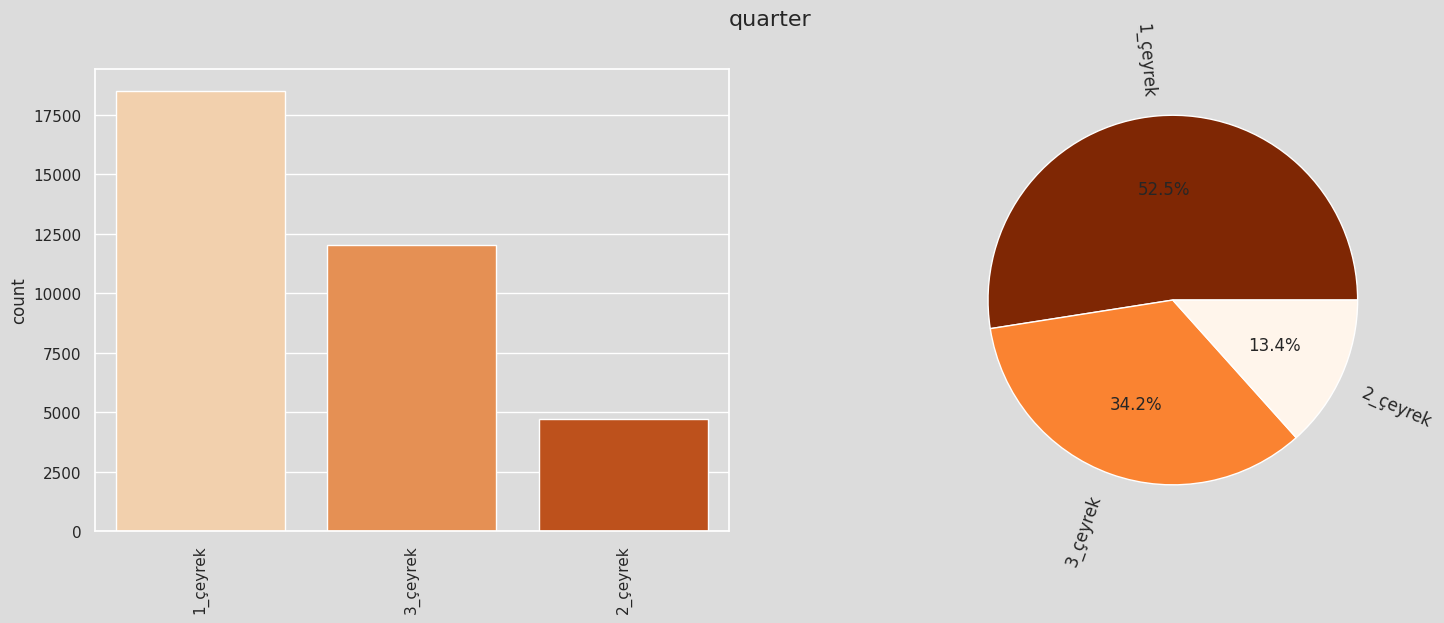

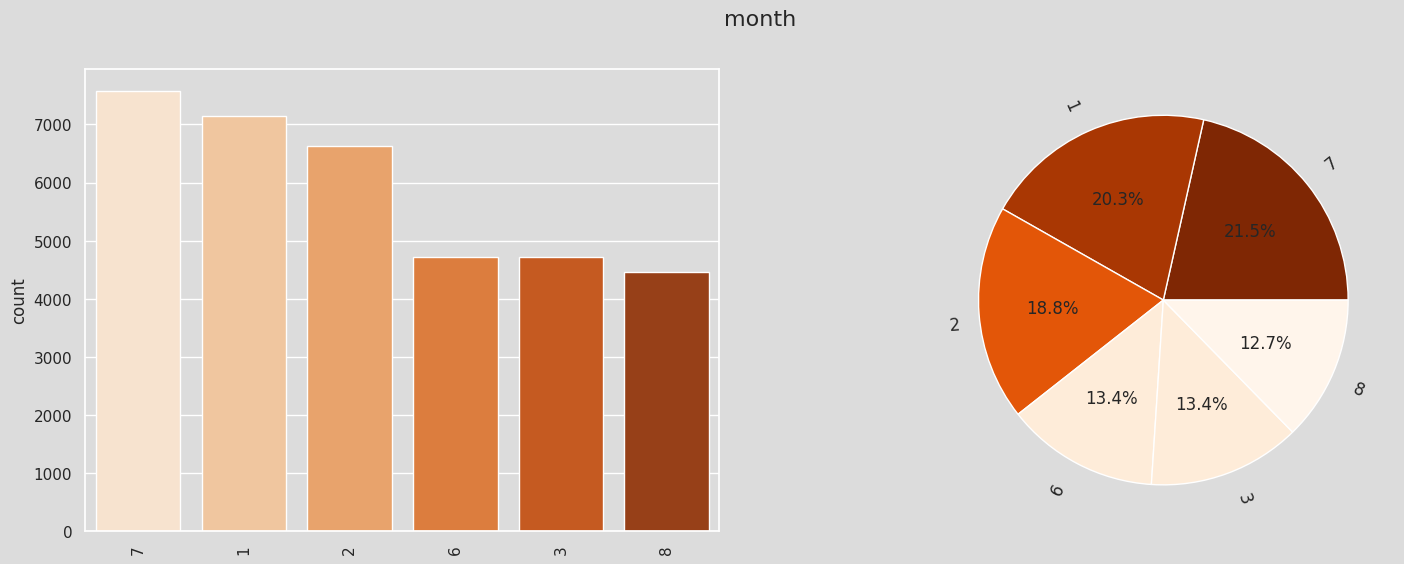

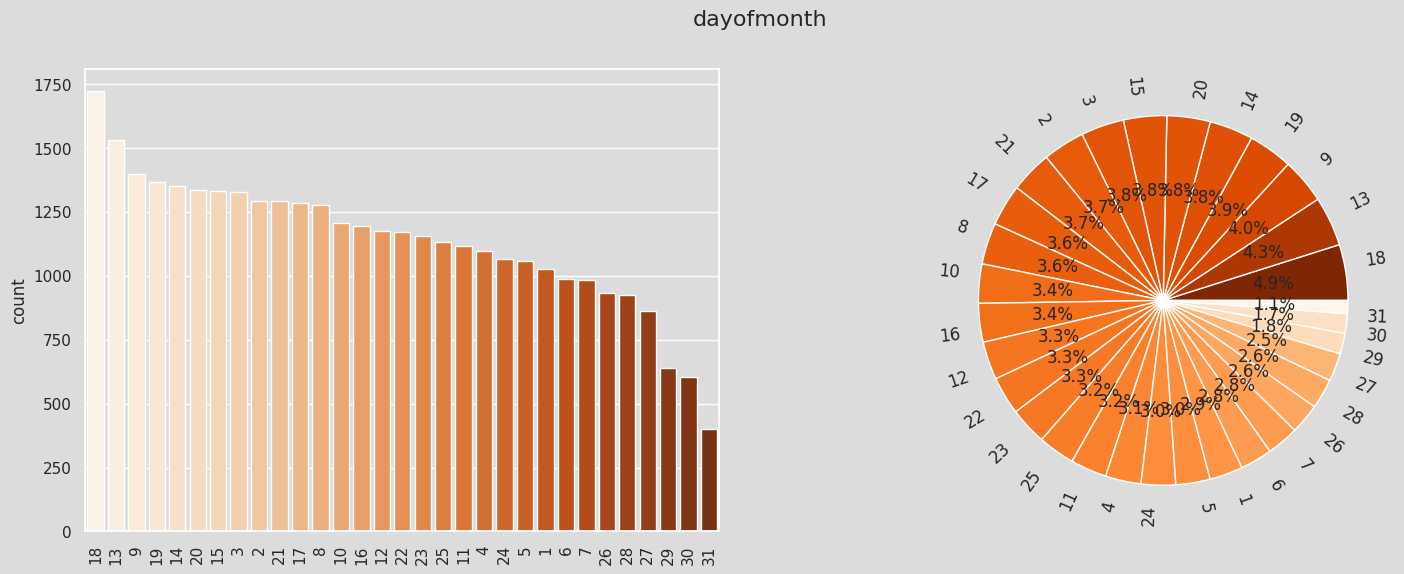

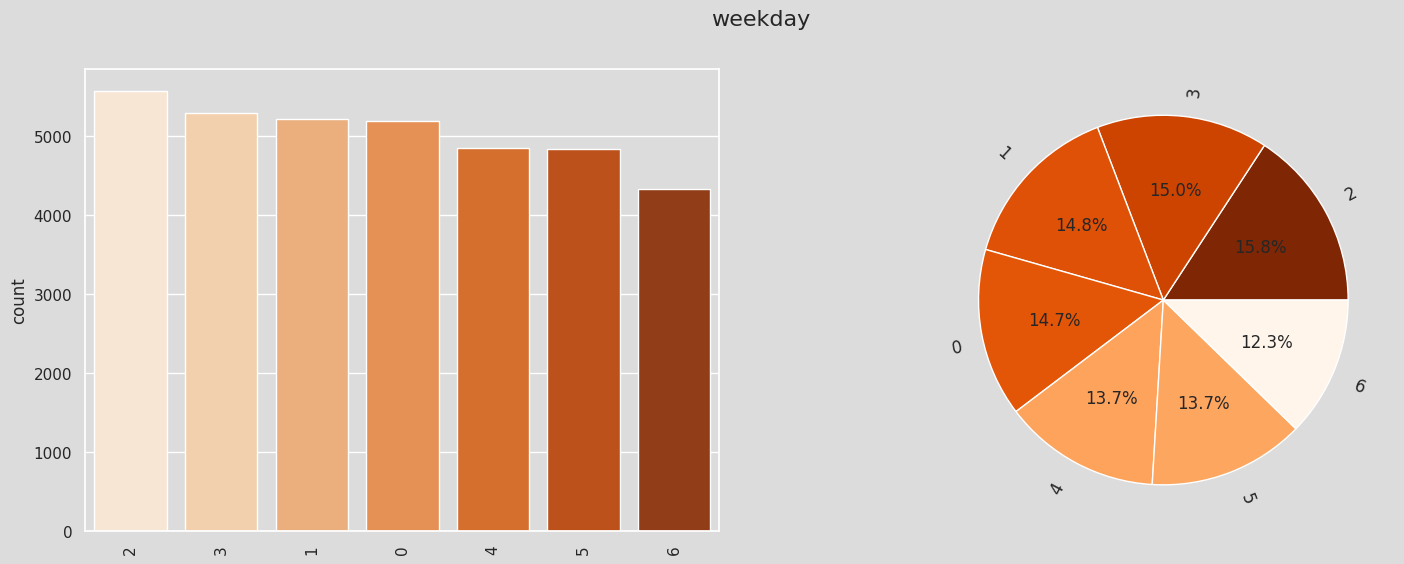

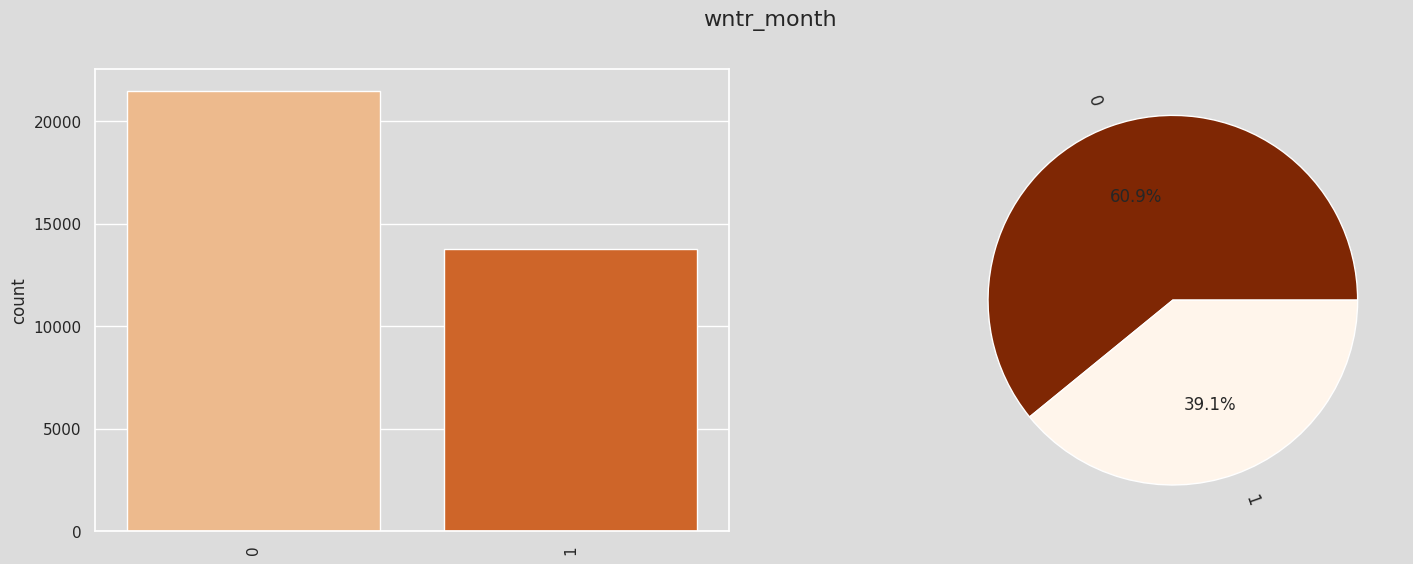

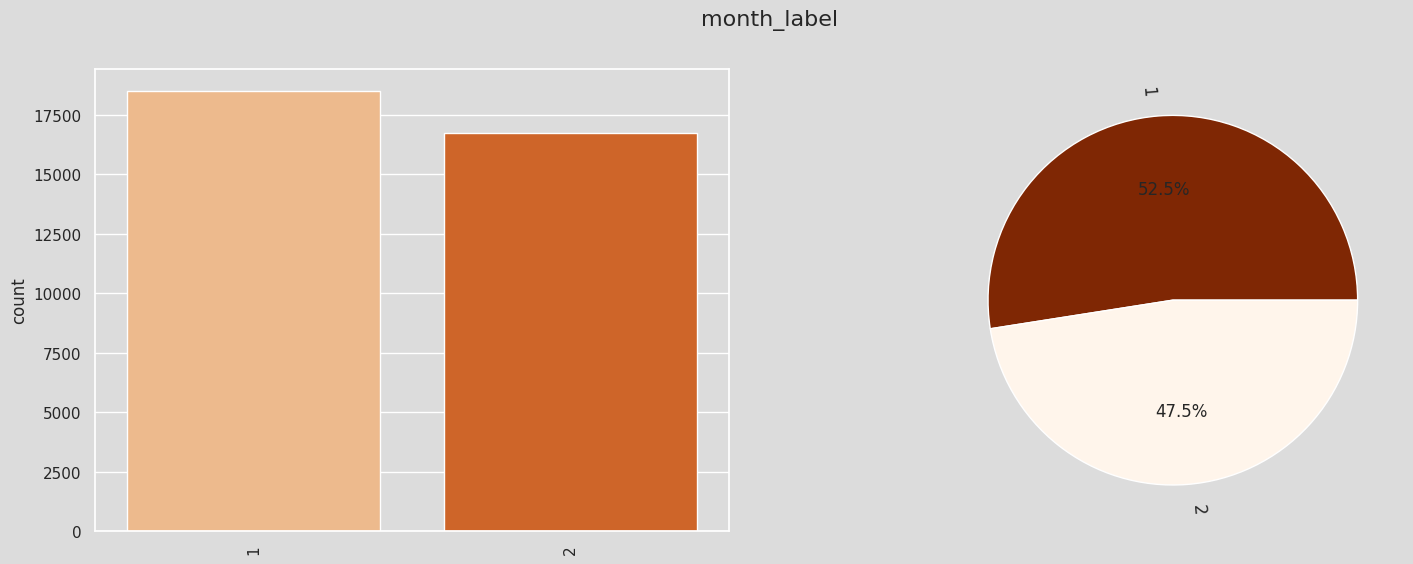

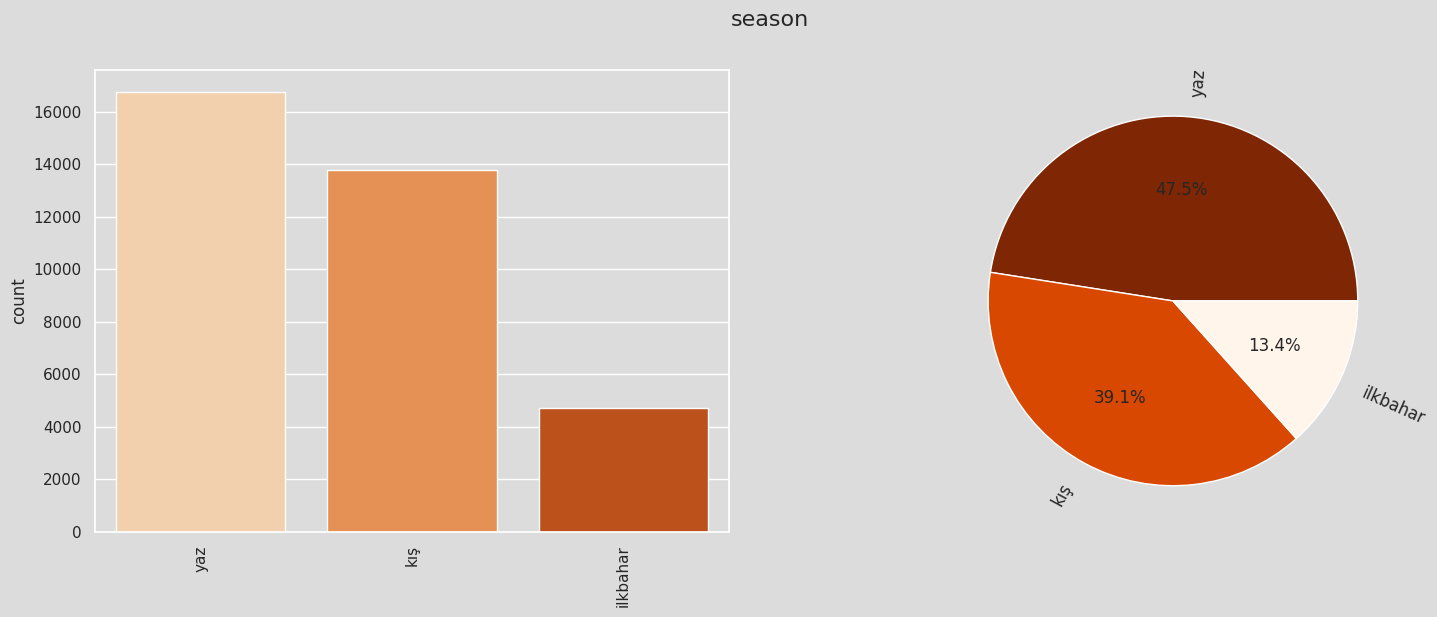

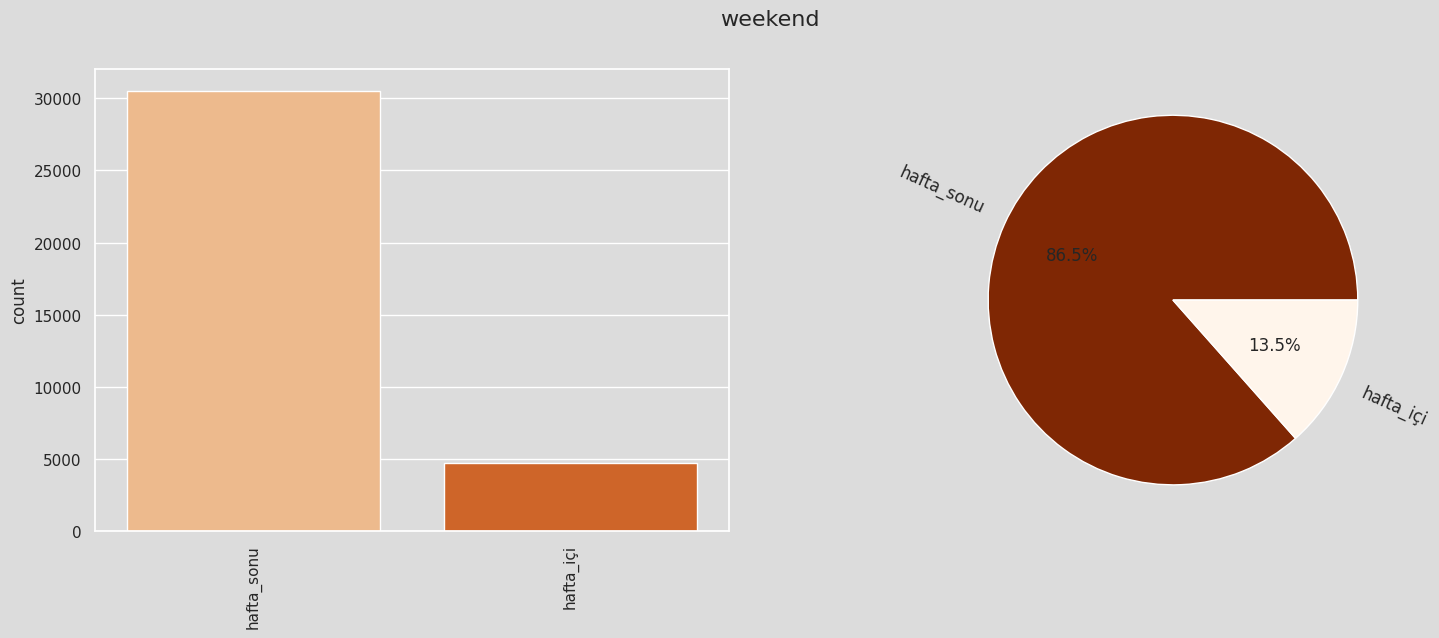

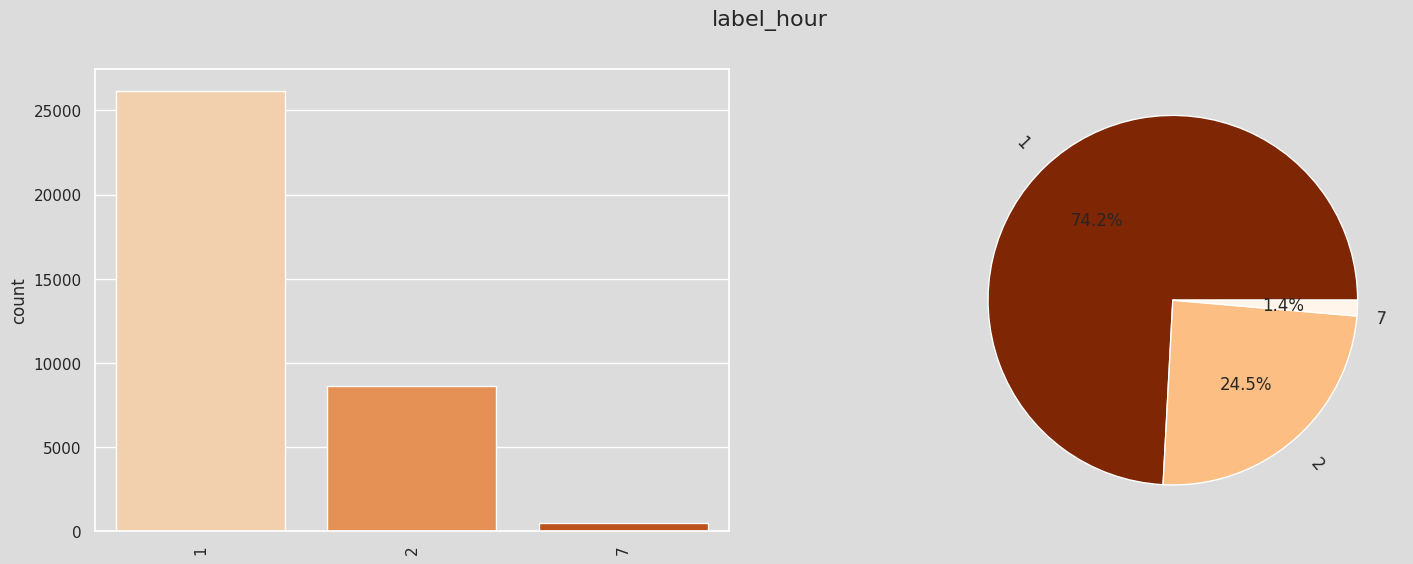

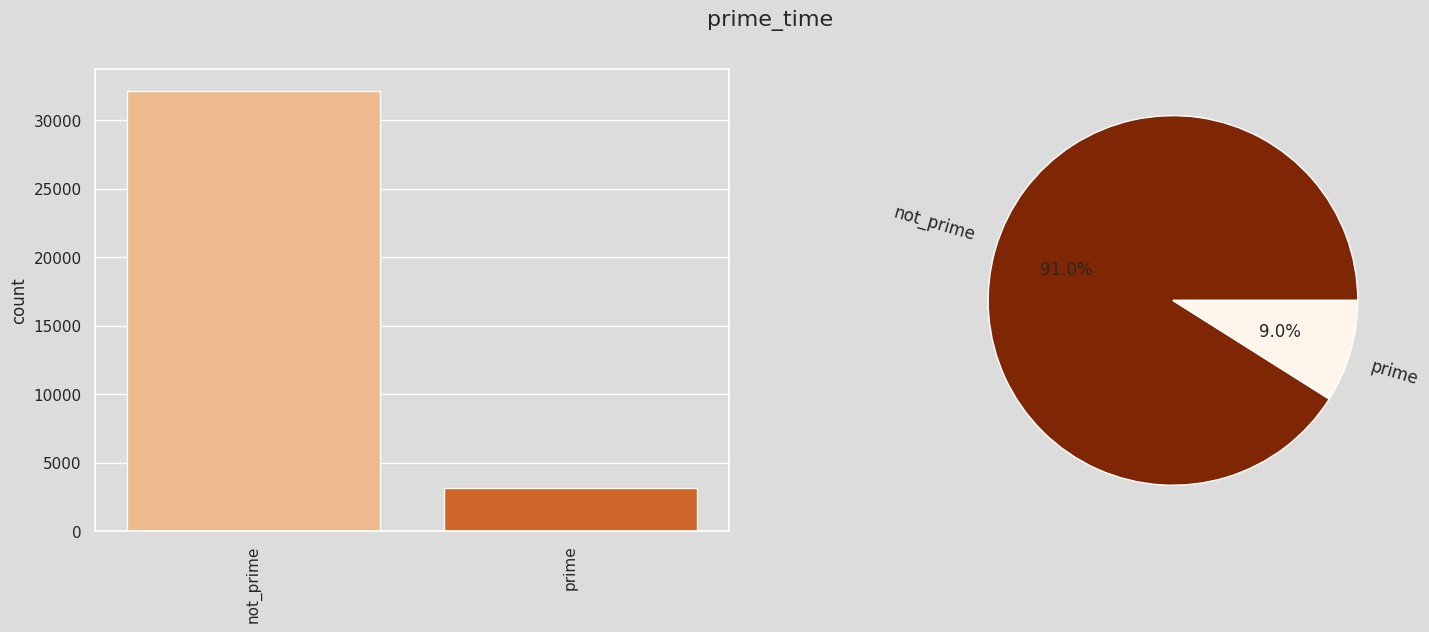

In [24]:
for col in obj_cols:
    cat_analyser(data, col)

# CATBOOST MODEL

* Setting the data to be inserted into the model. There are some features eliminated here.

In [25]:
data2=data.drop([
#'sebeke_unsuru',
#'kesinti_nedenine_iliskin_aciklama', 
#'kaynaga_gore',
#'sureye_gore',
#'sebebe_gore',
# 'il_ilce',
'baslama_tarihi_ve_zamani',
'sona_erme_tarihi_ve_zamani',
#'year', 
#'month',
#'grup_10',
#'dayofmonth',
#'time', 
#'time_label',
#'week'
],axis=1)
cat_features=[col for col in data2.columns if data2[col].dtype==object or data2[col].dtype=='category']
def label_data(feature,data,le_fit=None):
    if type(feature)==str:
        feature=[feature]
    for col in feature:
        le=LabelEncoder()
        le_fit.update({col:le.fit(data[col])})
        data[col]=le.transform(data[col])
    return data[feature],le_fit

data2[cat_features],_=label_data(cat_features,data2,{})

data_dum=data2.copy()
data_train=data_dum[data_dum.cagri_count.notnull()][1:]
train_target=data_train.cagri_count
data_train.drop(['cagri_count'],axis=1,inplace=True)
data_test=data_dum[data_dum.cagri_count.isnull()]
data_test.drop(['cagri_count'],axis=1,inplace=True)
print('data_dum shape: {}'.format(data_dum.shape))
print('data_train shape: {}'.format(data_train.shape))
print('data_test shape: {}'.format(data_test.shape))
cat_features

data_dum shape: (35247, 70)
data_train shape: (18494, 69)
data_test shape: (16752, 69)


/tmp/ipykernel_18523/2794137152.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(['cagri_count'],axis=1,inplace=True)


['il',
 'ilce',
 'sebeke_unsuru',
 'kesinti_nedenine_iliskin_aciklama',
 'kaynaga_gore',
 'sureye_gore',
 'sebebe_gore',
 'il_ilce',
 'hour',
 'dayofweek',
 'quarter',
 'month',
 'dayofmonth',
 'weekday',
 'wntr_month',
 'month_label',
 'season',
 'weekend',
 'label_hour',
 'prime_time',
 'nufus_label']

In [26]:
ss

NameError: name 'ss' is not defined

In [ ]:
from catboost import CatBoostRegressor
TUNE = True
KF=KFold(n_splits=3, random_state=None, shuffle=True)

def objective(trial,data=data_train,target=train_target):   

    catboost_params = {"subsample": trial.suggest_float("subsample", 0.5, 0.99),
                        'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                        "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
                        "max_depth": trial.suggest_int("max_depth", 4, 10, step=1),
                        "n_estimators": 1000,
                        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1)}
#     ,
#                         'task_type':"GPU",
#                         'devices':'0:1'}

    tscv_splits = list(KF.split(data,target))  
    rms_errs = []
    
    for split_train, split_val in tscv_splits:
        train_x, train_y = data.iloc[split_train], target.iloc[split_train]
        test_x, test_y = data.iloc[split_val], target.iloc[split_val]
        
        mcat = CatBoostRegressor(**catboost_params)
        mcat.fit(train_x, train_y,
                use_best_model = True,
                early_stopping_rounds = 50,
                 verbose=0,
                  eval_set=(test_x, test_y),
                 cat_features=cat_features
                )
        preds = mcat.predict(test_x)
        rms = mean_squared_error(test_y, preds, squared=False)
        rms_errs.append(rms)
        
    return np.mean(rms_errs)


if TUNE:
    study = optuna.create_study(direction = 'minimize')
    study.optimize(objective, n_trials = 80)
    print('Best value:', study.best_value)

* Best paramters obtained from optuna tuned 
>cat_best_params={
 'subsample': 0.9617328247354884, 'od_wait': 16, 'colsample_bylevel': 0.6547746313185058, 'random_strength': 6, 'l2_leaf_reg': 1.5189220321913304, 'max_depth': 8, 'learning_rate': 0.08784068449502132
    ,"n_estimators": 1000} 

In [ ]:
cat_best_params={
'subsample': 0.9617328247354884, 'od_wait': 16, 'colsample_bylevel': 0.6547746313185058, 'random_strength': 6, 'l2_leaf_reg': 1.5189220321913304, 'max_depth': 8, 'learning_rate': 0.08784068449502132
    ,"n_estimators": 1000}
KF=KFold(n_splits=3, random_state=None, shuffle=True)
def get_cv_result(model):

    cv_result = cross_val_score(model, data_train,train_target,
                                cv=KF, scoring="neg_root_mean_squared_error",
                                verbose=2)
    print(-cv_result)
    print("RMSE: %0.2f (+/- %0.2f)" % (-cv_result.mean(), cv_result.std()))
    return model
# ------------------------------------------------------
model = CatBoostRegressor(**cat_best_params,verbose=0)
_ = get_cv_result(model)

all_models = []
for i in [234,42]:
    cat_best_params["random_state"] = i
    model =  CatBoostRegressor(**cat_best_params)
    model = model.fit(data_train,train_target,verbose=0)
    all_models.append(model)

cat_preds = [model.predict(data_test) for model in all_models]
cat_mean_preds = np.mean(cat_preds, axis=0)


# Ploting Predicted values

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(cat_mean_preds)

# Feature importances 

In [ ]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':data_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
dum.features=dum.features.map(lambda x:  '_'.join(x) if type(x)==tuple else x)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);
